In [1]:
import pandas as pd
import numpy as np
from math import pi, cos, sin, acos, exp, log, sqrt, tan


def ETref(df, lat, elevation):
    """
    This function takes a DataFrame and adds various calculated columns
    for meteorological and agricultural research.
    """
    # Julian Date (day)
    ###
    # Julian Date represents the number of days since January 1st of each year.
    df['Julian Date (day)'] = (
        df['Date'] - pd.to_datetime(df['Date'].dt.year.astype(str) + '-01-01')).dt.days + 1

    # U2 (Wind Speed at 2m) in meters per second (m/s)
    # Formula: U2 = U3 * (4.87 / ln(67.8 * 3 - 5.42))
    df['U2 (m/s)'] = df['U3_m_s-1'] * (4.87 / np.log(67.8 * 3 - 5.42))

    # Rs (Solar Radiation) in MegaJoules per square meter per day (MJ/m²/day)
    # Formula: Rs = G * 0.0864
    df['Rs (MJ/m²/day)'] = df['Rs_W_m2'] * 0.0864

    # # Rhmax_adj (Adjusted Max Relative Humidity) in percentage (%)
    # # Formula: Rhmax_adj = min(Rh_max, 100)
    # df['Rhmax_adj (%)'] = np.minimum(df['Rhmax_%'], 100)

    # # Rh_avg (Average Relative Humidity) in percentage (%)
    # # Formula: Rh_avg = (Rh_min + Rhmax_adj) / 2
    # df['Rh_avg (%)'] = (df['Rhmin_%'] + df['Rhmax_adj (%)']) / 2

    # Tavg (Average Temperature) in degrees Celsius (°C)
    # Formula: Tavg = (Tmin + Tmax) / 2
    df['Tavg (°C)'] = (df['Tmax_C'] + df['Tmin_C']) / 2
    df['Tavg (°C)'] = pd.to_numeric(df['Tavg (°C)'], errors='raise')

    # Lambda (λ) in MegaJoules per kilogram (MJ/kg)
    # Formula: Lambda = 2.501 - (2.361e-3 * Tavg)
    df['Lambda (MJ/kg)'] = 2.501 - (2.361e-3 * df['Tavg (°C)'])

    # P (Atmospheric Pressure) in kiloPascals (kPa)
    # Formula: P = 101.3 * ((293 - 0.0065 * 552) / 293)^5.26
    df['P (kPa)'] = 101.3 * ((293 - 0.0065 * elevation) / 293)**5.26  # correct

    # Gamma (ϒ) in kiloPascals per degree Celsius (kPa/°C)
    # Formula: Gamma = (1.013 * P) / (0.622 * Lambda) * 1e-3
    df['Gamma (kPa/°C)'] = ((1.013 * 1e-3 * df['P (kPa)']) /
                            (0.622 * df['Lambda (MJ/kg)']))

    # Delta (∆) in kiloPascals per degree Celsius (kPa/°C)
    # Formula: Delta = (4098 * (0.6108 * exp(17.27 * Tavg / (Tavg + 237.3)))) / (Tavg + 237.3)^2
    df['Delta (kPa/°C)'] = (4098 * (0.6108 * np.exp(17.27 * df['Tavg (°C)'] /
                                                    (df['Tavg (°C)'] + 237.3)))) / ((df['Tavg (°C)'] + 237.3)**2)

    # eᵒ(Tmax) (Saturation Vapor Pressure at Tmax) in kiloPascals (kPa)
    # Formula: eᵒ(Tmax) = 0.6108 * exp(17.27 * Tmax / (Tmax + 237.3))
    df['eᵒ(Tmax) (kPa)'] = 0.6108 * np.exp(17.27 *
                                           df['Tmax_C'] / (df['Tmax_C'] + 237.3))

    # eᵒ(Tmin) (Saturation Vapor Pressure at Tmin) in kiloPascals (kPa)
    # Formula: eᵒ(Tmin) = 0.6108 * exp(17.27 * Tmin / (Tmin + 237.3))
    df['eᵒ(Tmin) (kPa)'] = 0.6108 * np.exp(17.27 *
                                           df['Tmin_C'] / (df['Tmin_C'] + 237.3))

    # eᵒs (Average Saturation Vapor Pressure) in kiloPascals (kPa)
    # Formula: eᵒs = (eᵒ(Tmax) + eᵒ(Tmin)) / 2
    df['eᵒs (kPa)'] = (df['eᵒ(Tmax) (kPa)'] + df['eᵒ(Tmin) (kPa)']) / 2

    # eᵒa (Actual Vapor Pressure) in kiloPascals (kPa)
    # Formula: eᵒa = eᵒs * (Rh_avg / 100)
    # df['eᵒa (kPa)'] = ((df['eᵒ(Tmin) (kPa)'] * (df['Rhmax_adj (%)']/100)
    #                     ) + (df['eᵒ(Tmax) (kPa)'] * (df['Rhmin_%']/100)))/2
    df['eᵒa (kPa)']=0.6108*np.exp(17.27*df["T_dew_C"]/(df["T_dew_C"]+237.3))
    # VPD (Vapor Pressure Deficit) in kiloPascals (kPa)
    # Formula: VPD = eᵒs - eᵒa
    df['VPD (kPa)'] = df['eᵒs (kPa)'] - df['eᵒa (kPa)']

    # dr (Inverse Relative Distance Earth-Sun)
    # Formula: dr = 1 + 0.033 * cos(2π * Julian Date (day) / 365)
    df['Inverse Relative Distance Earth-Sun'] = 1 + 0.033 * \
        np.cos(2 * np.pi * df['Julian Date (day)'] / 365)

    # δ (Solar Declination) in radians (rad)
    # Formula: δ = 0.409 * sin(2π * Julian Date (day) / 365 - 1.39)
    df['Solar Declination (rad)'] = 0.409 * np.sin((2 *
                                                    np.pi * df['Julian Date (day)'] / 365) - 1.39)

    # ωs (Sunset Hour Angle) in radians (rad)
    # Formula: ωs = acos(-tan(lat) * tan(δ))
    df['Sunset Hour Angle (rad)'] = np.arccos(-np.tan(lat)
                                              * np.tan(df['Solar Declination (rad)']))

    # Ra (Extraterrestrial Radiation) in MegaJoules per square meter per day (MJ/m²/day)
    # Formula: Ra = (24 * 60 / π) * Gsc * dr * (ws*sin(lat) * sin(δ) + cos(lat) * cos(δ) * sin(ωs))
    df['Ra (MJ/m²/day)'] = (24 * 60 / np.pi) * 0.082 * df['Inverse Relative Distance Earth-Sun'] * (df['Sunset Hour Angle (rad)']*np.sin(lat)
                                                                                                    * np.sin(df['Solar Declination (rad)']) + (np.cos(lat) * np.cos(df['Solar Declination (rad)']) * np.sin(df['Sunset Hour Angle (rad)'])))

    # Rso (Clear Sky Solar Radiation) in MegaJoules per square meter per day (MJ/m²/day)
    # Formula: Rso = (0.75 + 2e-5 * 552) * Ra
    df['Rso (MJ/m²/day)'] = (0.75 + 2e-5 * elevation) * df['Ra (MJ/m²/day)']

    # Rns (Net Solar Radiation) in MegaJoules per square meter per day (MJ/m²/day)
    # Formula: Rns = (1 - 0.23) * Rs
    df['Rns (MJ/m²/day)'] = (1 - 0.23) * \
        df['Rs (MJ/m²/day)']  # we need alfaalfa albedo

    # Rnl (Net Longwave Radiation) in MegaJoules per square meter per day (MJ/m²/day)
    # Formula: Rnl = (4.903e-9 * ((Tavg + 273.16)^4 + (Tmin + 273.16)^4) / 2 * (0.34 - 0.14 * sqrt(eᵒa)) * (1.35 * Rns / Rso) - 0.35)
    df['Rnl (MJ/m²/day)'] = (4.903e-9 * ((df['Tavg (°C)'] + 273.16)**4 + (df['Tmin_C'] + 273.16)**4) / 2) * (0.34 -
                                                                                                             0.14 * np.sqrt(df['eᵒa (kPa)'])) * ((1.35 * np.minimum(df['Rs (MJ/m²/day)'] / df['Rso (MJ/m²/day)'], 1) - 0.35))

    # Rn (Net Radiation) in MegaJoules per square meter per day (MJ/m²/day)
    # Formula: Rn = Rns - Rnl
    df['Rn (MJ/m²/day)'] = df['Rns (MJ/m²/day)'] - df['Rnl (MJ/m²/day)']

    # ETo (Reference Evapotranspiration) in millimeters per day (mm/day)
    # ETo (Reference Evapotranspiration) in millimeters per day (mm/day)
    #df['ETo (mm/day)'] = (0.408 * df['Delta (kPa/°C)'] * df['Rn (MJ/m²/day)'] + df['Gamma (kPa/°C)'] * (900 / (df['Tavg (°C)'] + 273))
                          #* df['U2 (m/s)'] * df['VPD (kPa)']) / (df['Delta (kPa/°C)'] + df['Gamma (kPa/°C)'] * (1 + 0.34 * df['U2 (m/s)']))
    # ETo (Reference Evapotranspiration) in inches per day (in/day)
    df['ETo (in/day)'] = (0.408 * df['Delta (kPa/°C)'] * df['Rn (MJ/m²/day)'] + df['Gamma (kPa/°C)'] * (900 / (df['Tavg (°C)'] + 273))
                          * df['U2 (m/s)'] * df['VPD (kPa)']) / (df['Delta (kPa/°C)'] + df['Gamma (kPa/°C)'] * (1 + 0.34 * df['U2 (m/s)'])) * 0.0393701

    # ETr (Reference Evapotranspiration for grass) in millimeters per day (mm/day)
   # df['ETr (mm/day)'] = (0.408 * df['Delta (kPa/°C)'] * df['Rn (MJ/m²/day)'] + df['Gamma (kPa/°C)'] * (1600 / (df['Tavg (°C)'] + 273))
                          #* df['U2 (m/s)'] * df['VPD (kPa)']) / (df['Delta (kPa/°C)'] + df['Gamma (kPa/°C)'] * (1 + 0.38 * df['U2 (m/s)']))
    # ETr (Reference Evapotranspiration for grass) in millimeters per day (in/day)
    df['ETr (in/day)'] = (0.408 * df['Delta (kPa/°C)'] * df['Rn (MJ/m²/day)'] + df['Gamma (kPa/°C)'] * (1600 / (df['Tavg (°C)'] + 273))
                          * df['U2 (m/s)'] * df['VPD (kPa)']) / (df['Delta (kPa/°C)'] + df['Gamma (kPa/°C)'] * (1 + 0.38 * df['U2 (m/s)'])) * 0.0393701

    return df



### Becker and Sherbourne 2022 and 2023

In [2]:
import pandas as pd

# Load the CSV file
df_GEMS_Sherbourne2022 = pd.read_csv('Gemsexchage_data/gems_weather_export_sherbourne_2022-01-01_to_2022-12-31_units(M).csv')

# Make sure 'Date' is in datetime format
df_GEMS_Sherbourne2022['Date'] = pd.to_datetime(df_GEMS_Sherbourne2022['Date'])

#Rename columns if necessary
df_GEMS_Sherbourne2022.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1','solar_rad' : 'Rs_W_m2','max_temp' : 'Tmax_C' , 'min_temp':'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define your latitude and elevation
latitude = 0.792 #  latitude of the location in radian
elevation = 287  #  the actual elevation of the location in meters #Here I kept same elevation as Becker. 

#  Call the ETref function
df_GEMS_Sherbourne2022 = ETref(df_GEMS_Sherbourne2022, latitude, elevation)

# Check the new columns added to your DataFrame
print(df_GEMS_Sherbourne2022.head)



<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4738   -22.2  67   987      342 2022-01-01   
1             1      1   4753   -17.2  70   988      344 2022-01-02   
2             2      2   4770    -4.4  74   983      345 2022-01-03   
3             3      3   4787    -2.2  81   968      347 2022-01-04   
4             4      4   4806    -8.3  76   975      349 2022-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4678   -11.2  66   986      337 2022-12-26   
360         360    360   4687    -1.9  71   969      337 2022-12-27   
361         361    361   4697     2.8  77   959      338 2022-12-28   
362         362    362   4708     0.8  86   966      339 2022-12-29   
363         363    363   4721    -6.0  77   977      340 2022-12-30   

     max_wind_spd  precip_gpm  ...  Inverse Relative Distance Earth-Sun  \
0             3.0         0.0  ...        

In [3]:
df_BeckerMDA_2022 = pd.read_csv('MDAclean_data/Becker_clean_MDA_2022.csv')

In [4]:
df_BeckerMDA_2022

,TIMESTAMP,RAIN_daily_in,RAIN_cmltv_in,AIRTEMP_daily_max_F,AIRTEMP_F_TMx,AIRTEMP_daily_min_F,AIRTEMP_F_TMn,AIRTEMP_daily_avg_F,RLTVHMDTY_daily_max_%,RH_TMx,...,WNDSP_daily_min_mph,WNDSP_mph_TMn,WNDSP_daily_avg_mph,WND_DIR_daily_dgr,WND_DIR_daily_crdn,SolarFlux_daily_lnglys,SolarRad_daily_mj,ETos_daily_in,ETrs_daily_in,CornGDD_daily
0,1/1/2022 23:59,0.00,0.00,-9.190,1/1/2022 0:23,-18.790,1/1/2022 8:18,-14.120,75.56,1/1/2022 23:40,...,0.596,1/1/2022 22:12,7.815,311.2,NW,136.09570,6.908741,0.006,0.007,0.0
1,1/2/2022 23:59,0.00,0.00,2.477,1/2/2022 23:56,-19.280,1/2/2022 7:56,-8.480,80.30,1/2/2022 9:46,...,0.000,1/2/2022 5:51,3.746,206.5,SSW,162.53420,6.921883,0.007,0.009,0.0
2,1/3/2022 23:59,0.03,0.03,23.470,1/3/2022 13:58,1.806,1/3/2022 0:00,11.350,89.40,1/3/2022 23:54,...,0.000,1/3/2022 0:10,3.538,150.1,SSE,105.23420,6.822431,0.009,0.012,0.0
3,1/4/2022 23:59,0.00,0.03,26.740,1/4/2022 14:56,4.436,1/4/2022 2:53,16.660,93.80,1/4/2022 22:58,...,0.000,1/4/2022 0:04,7.237,103.7,NE,93.91601,6.811567,0.012,0.016,0.0
4,1/5/2022 23:59,0.00,0.03,18.590,1/4/2022 23:59,-1.810,1/5/2022 23:55,7.683,88.30,1/4/2022 23:59,...,8.270,1/5/2022 21:54,16.680,320.6,NW,114.26520,6.992534,0.011,0.016,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,12/26/2022 23:59,0.00,26.65,11.060,12/26/2022 15:42,-2.123,12/26/2022 7:53,3.407,77.52,12/26/2022 22:18,...,0.000,12/26/2022 4:51,5.357,230.3,NW,161.28690,6.656814,0.011,0.013,0.0
360,12/27/2022 23:59,0.01,26.66,26.020,12/27/2022 22:55,1.245,12/27/2022 0:00,16.350,82.30,12/27/2022 19:30,...,1.193,12/27/2022 0:14,7.987,167.8,SSE,142.83720,6.576760,0.017,0.025,0.0
361,12/28/2022 23:59,0.02,26.68,36.610,12/28/2022 14:34,24.750,12/27/2022 23:59,32.390,87.80,12/28/2022 23:54,...,0.000,12/28/2022 0:08,5.005,154.5,SSE,94.22280,6.449224,0.018,0.026,0.0
362,12/29/2022 23:59,0.00,26.68,33.970,12/29/2022 1:09,16.270,12/29/2022 23:57,27.870,97.40,12/29/2022 5:46,...,0.000,12/29/2022 0:02,5.553,263.7,W,67.28857,6.469079,0.009,0.012,0.0


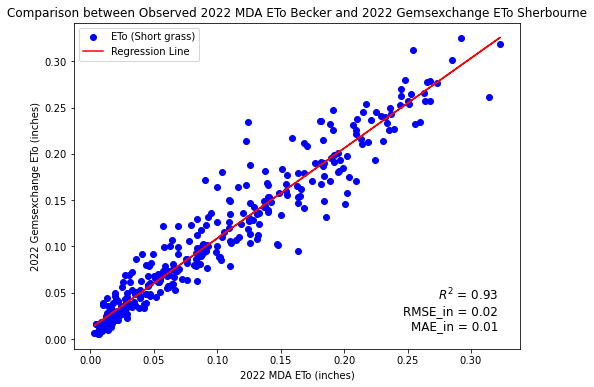

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Assuming df_Becker and df are your DataFrames containing observed MDA ETr and observed Gemsexchange ETr respectively

# Observed MDA ETo
mda_eto = df_BeckerMDA_2022['ETos_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETo
gems_weatherbit_eto = df_GEMS_Sherbourne2022['ETo (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_eto, gems_weatherbit_eto)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_eto, model.predict(mda_eto))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_eto, model.predict(mda_eto))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_eto, model.predict(mda_eto)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_eto, gems_weatherbit_eto, color='blue', label='ETo (Short grass)')
plt.plot(mda_eto, slope * mda_eto + intercept, color='red', label='Regression Line')
plt.xlabel('2022 MDA ETo (inches)')
plt.ylabel('2022 Gemsexchange ETo (inches)')
plt.title('Comparison between Observed 2022 MDA ETo Becker and 2022 Gemsexchange ETo Sherbourne')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


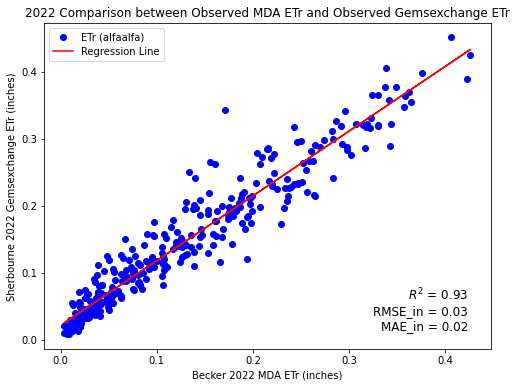

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Assuming df_Becker and df are your DataFrames containing observed MDA ETr and observed Gemsexchange ETr respectively

# Observed MDA ETr
mda_etr = df_BeckerMDA_2022['ETrs_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etr = df_GEMS_Sherbourne2022['ETr (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_etr, gems_weatherbit_etr)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etr, model.predict(mda_etr))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etr, model.predict(mda_etr))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etr, model.predict(mda_etr)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_etr, gems_weatherbit_etr, color='blue', label='ETr (alfaalfa)')
plt.plot(mda_etr, slope * mda_etr + intercept, color='red', label='Regression Line')
plt.xlabel('Becker 2022 MDA ETr (inches)')
plt.ylabel('Sherbourne 2022 Gemsexchange ETr (inches)')
plt.title('2022 Comparison between Observed MDA ETr and Observed Gemsexchange ETr')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


In [7]:
import pandas as pd

# Load the CSV file
df_GEMS_Sherbourne2023 = pd.read_csv('Gemsexchage_data/gems_weather_export_sherbourne_2023-01-01_to_2023-12-31_units(M).csv')

# Make sure 'Date' is in datetime format
df_GEMS_Sherbourne2023['Date'] = pd.to_datetime(df_GEMS_Sherbourne2022['Date'])

#Rename columns if necessary
df_GEMS_Sherbourne2023.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1','solar_rad' : 'Rs_W_m2','max_temp' : 'Tmax_C' , 'min_temp':'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define your latitude and elevation
latitude = 0.792 #  latitude of the location in radian
elevation = 287  #  the actual elevation of the location in meters #Here I kept same elevation as Becker. 

#  Call the ETref function
df_GEMS_Sherbourne2023 = ETref(df_GEMS_Sherbourne2023, latitude, elevation)

# Check the new columns added to your DataFrame
print(df_GEMS_Sherbourne2023.head)



<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4738     1.0  87   975      342 2022-01-01   
1             1      1   4753    -4.2  90   981      344 2022-01-02   
2             2      2   4770    -0.6  89   970      345 2022-01-03   
3             3      3   4787     0.2  89   969      347 2022-01-04   
4             4      4   4806    -3.0  85   977      349 2022-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4678     7.5  87   974      337 2022-12-26   
360         360    360   4687     1.1  89   981      337 2022-12-27   
361         361    361   4697     2.1  89   982      338 2022-12-28   
362         362    362   4708     5.7  81   977      339 2022-12-29   
363         363    363   4721     0.0  83   974      340 2022-12-30   

     max_wind_spd  precip_gpm  ...  Inverse Relative Distance Earth-Sun  \
0             3.7         0.0  ...        

In [8]:
df_BeckerMDA_2023 = pd.read_csv('MDAclean_data/Becker_clean_MDA_2023.csv')
df_BeckerMDA_2023

,TIMESTAMP,RECORD,BATT_daily_min_V,RAIN_daily_in,RAIN_cmltv_in,AIRTEMP_daily_max_F,AIRTEMP_F_TMx,AIRTEMP_daily_min_F,AIRTEMP_F_TMn,AIRTEMP_daily_avg_F,...,WNDSP_daily_min_mph,WNDSP_mph_TMn,WNDSP_daily_avg_mph,WND_DIR_daily_dgr,WND_DIR_daily_crdn,SolarFlux_daily_lnglys,SolarRad_daily_mj,ETos_daily_in,ETrs_daily_in,CornGDD_daily
0,1/1/2023 23:59,669,12.47,0.00,0.00,33.74,1/1/2023 0:04,22.100,1/1/2023 23:57,26.32,...,1.043,1/1/2023 11:05,6.555,273.10,W,121.49840,6.618053,0.014,0.018,0.0
1,1/2/2023 23:59,670,12.43,0.00,0.00,23.05,1/2/2023 15:33,20.380,1/2/2023 10:49,21.90,...,0.000,1/2/2023 5:21,2.570,203.40,WNW,75.01989,6.689792,0.006,0.007,0.0
2,1/3/2023 23:59,671,12.37,0.00,0.00,29.55,1/3/2023 23:47,18.650,1/3/2023 8:16,23.46,...,2.385,1/3/2023 12:10,11.180,39.26,NE,25.75769,6.741007,0.006,0.009,0.0
3,1/4/2023 23:59,672,12.31,0.02,0.02,30.29,1/4/2023 11:19,25.060,1/4/2023 23:51,27.96,...,4.696,1/4/2023 20:46,11.460,61.92,NNE,67.40713,6.690259,0.007,0.008,0.0
4,1/5/2023 23:59,673,12.27,0.00,0.02,25.34,1/5/2023 0:00,5.104,1/5/2023 21:27,18.86,...,0.000,1/5/2023 20:41,7.703,258.90,NW,115.44460,6.856583,0.008,0.010,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,12/26/2023 23:59,1028,11.95,0.21,3.67,45.06,12/26/2023 0:03,31.650,12/26/2023 23:46,36.56,...,0.000,12/26/2023 17:26,6.881,151.00,SSE,44.10003,6.354798,0.010,0.013,0.0
360,12/27/2023 23:59,1029,11.89,0.00,3.67,34.46,12/27/2023 13:46,30.010,12/27/2023 21:24,31.83,...,0.000,12/27/2023 0:46,1.841,207.40,WSW,45.27047,6.398251,0.009,0.012,0.0
361,12/28/2023 23:59,1030,11.84,0.00,3.67,35.80,12/28/2023 15:46,30.260,12/28/2023 23:02,32.76,...,0.000,12/27/2023 23:59,7.004,297.00,NNW,45.55449,6.412548,0.012,0.017,0.0
362,12/29/2023 23:59,1031,11.80,0.00,3.67,42.67,12/29/2023 14:54,23.460,12/29/2023 6:02,31.63,...,0.000,12/29/2023 5:56,4.246,259.10,WNW,159.73670,6.472487,0.019,0.023,0.0


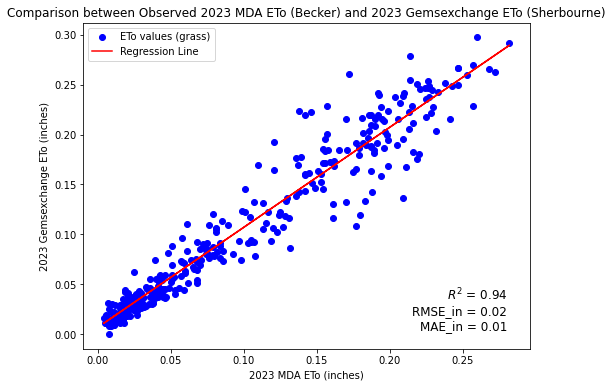

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Assuming df_Becker and df are your DataFrames containing observed MDA ETr and observed Gemsexchange ETr respectively

# Observed MDA ETo
mda_eto_Becker2023 = df_BeckerMDA_2023['ETos_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETo
gems_weatherbit_etoSher2023 = df_GEMS_Sherbourne2023['ETo (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_eto_Becker2023, gems_weatherbit_etoSher2023)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etoSher2023, model.predict(mda_eto_Becker2023))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etoSher2023, model.predict(mda_eto_Becker2023))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etoSher2023, model.predict(mda_eto_Becker2023)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_eto_Becker2023, gems_weatherbit_etoSher2023, color='blue', label='ETo values (grass)')
plt.plot(mda_eto_Becker2023, slope * mda_eto_Becker2023 + intercept, color='red', label='Regression Line')
plt.xlabel('2023 MDA ETo (inches)')
plt.ylabel('2023 Gemsexchange ETo (inches)')
plt.title('Comparison between Observed 2023 MDA ETo (Becker) and 2023 Gemsexchange ETo (Sherbourne)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


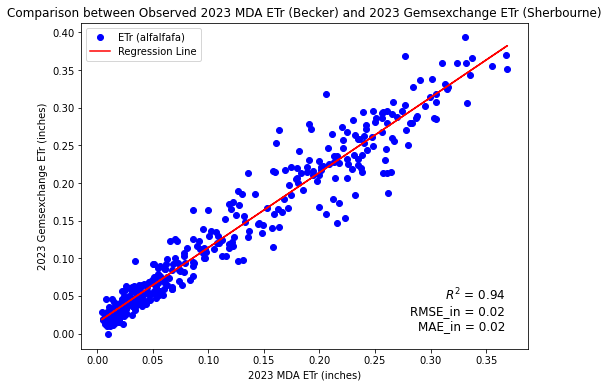

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Assuming df_Becker and df are your DataFrames containing observed MDA ETr and observed Gemsexchange ETr respectively

# Observed MDA ETr
mda_etr_Becker2023 = df_BeckerMDA_2023['ETrs_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etrSher2023 = df_GEMS_Sherbourne2023['ETr (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_etr_Becker2023, gems_weatherbit_etrSher2023)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etrSher2023, model.predict(mda_etr_Becker2023))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etrSher2023, model.predict(mda_etr_Becker2023))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etrSher2023, model.predict(mda_etr_Becker2023)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_etr_Becker2023, gems_weatherbit_etrSher2023, color='blue', label='ETr (alfalfafa)')
plt.plot(mda_etr_Becker2023, slope * mda_etr_Becker2023 + intercept, color='red', label='Regression Line')
plt.xlabel('2023 MDA ETr (inches)')
plt.ylabel('2023 Gemsexchange ETr (inches)')
plt.title('Comparison between Observed 2023 MDA ETr (Becker) and 2023 Gemsexchange ETr (Sherbourne)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


### Dakota and Hastings

In [15]:
import pandas as pd

# Load the CSV file
df_GEMS_Dakota2022 = pd.read_csv('Gemsexchage_data/gems_weather_export_dakota_2022-01-01_to_2022-12-31_units(M).csv')

# Make sure 'Date' is in datetime format
df_GEMS_Dakota2022['Date'] = pd.to_datetime(df_GEMS_Dakota2022['Date'])

#Rename columns if necessary
df_GEMS_Dakota2022.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1','solar_rad' : 'Rs_W_m2','max_temp' : 'Tmax_C' , 'min_temp':'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define your latitude and elevation
latitude = 0.7794 #  latitude of the location in radian
elevation = 249 #  the actual elevation of the location in meters #Here I kept same elevation as Becker. 

#  Call the ETref function
df_GEMS_Dakota2022 = ETref(df_GEMS_Dakota2022, latitude, elevation)

# Check the new columns added to your DataFrame
print(df_GEMS_Dakota2022.head)



<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4814   -17.0  70   992      350 2022-01-01   
1             1      1   4830   -16.3  69   995      352 2022-01-02   
2             2      2   4846    -4.1  70   989      353 2022-01-03   
3             3      3   4864    -0.4  79   974      355 2022-01-04   
4             4      4   4884    -3.3  79   979      357 2022-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4757   -11.5  71   994      344 2022-12-26   
360         360    360   4765    -5.2  70   980      345 2022-12-27   
361         361    361   4774     2.2  74   969      346 2022-12-28   
362         362    362   4785     1.9  86   974      347 2022-12-29   
363         363    363   4797    -2.6  80   985      348 2022-12-30   

     max_wind_spd  precip_gpm  ...  Inverse Relative Distance Earth-Sun  \
0             4.4         0.0  ...        

In [41]:
import pandas as pd

# Load the CSV file
df_GEMS_Dakota2023 = pd.read_csv('Gemsexchage_data/gems_weather_export_dakota_2023-01-01_to_2023-12-31_units(M).csv')

# Make sure 'Date' is in datetime format
df_GEMS_Dakota2023['Date'] = pd.to_datetime(df_GEMS_Dakota2023['Date'])

#Rename columns if necessary
df_GEMS_Dakota2023.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1','solar_rad' : 'Rs_W_m2','max_temp' : 'Tmax_C' , 'min_temp':'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define your latitude and elevation
latitude = 0.7794 #  latitude of the location in radian
elevation = 249 #  the actual elevation of the location in meters #Here I kept same elevation as Becker. 

#  Call the ETref function
df_GEMS_Dakota2023 = ETref(df_GEMS_Dakota2023, latitude, elevation)

# Check the new columns added to your DataFrame
print(df_GEMS_Dakota2023.head)


<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4814     1.5  89   983      350 2023-01-01   
1             1      1   4830    -3.0  91   989      352 2023-01-02   
2             2      2   4846     0.4  89   977      353 2023-01-03   
3             3      3   4864     0.7  92   975      355 2023-01-04   
4             4      4   4884    -0.7  87   984      357 2023-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
358         359    359   4757    10.0  82   982      344 2023-12-26   
359         360    360   4765     2.6  78   988      345 2023-12-27   
360         361    361   4774     1.1  87   989      346 2023-12-28   
361         362    362   4785     4.1  85   985      347 2023-12-29   
362         363    363   4797    -1.5  88   981      348 2023-12-30   

     max_wind_spd  precip_gpm  ...  Inverse Relative Distance Earth-Sun  \
0             3.2         0.0  ...        

In [42]:
df_HastingsMDA_2022 = pd.read_csv('MDAclean_data/Hastings_clean_MDA_2022.csv')
df_HastingsMDA_2023 = pd.read_csv('MDAclean_data/Hastings_clean_MDA_2023.csv')


# Select the first 364 rows
df_HastingsMDA_2023 = df_HastingsMDA_2023.iloc[:363]

# Print the DataFrame
print(df_HastingsMDA_2023)

            TIMESTAMP  RECORD  BATT_daily_min_V  RAIN_daily_in  RAIN_cmltv_in  \
0      1/1/2023 23:59   754.0             12.26           0.00           0.00   
1      1/2/2023 23:59   755.0             12.17           0.00           0.00   
2      1/3/2023 23:59   756.0             12.03           0.00           0.00   
3      1/4/2023 23:59   757.0             11.89           0.29           0.29   
4      1/5/2023 23:59   758.0             11.81           0.04           0.33   
..                ...     ...               ...            ...            ...   
358  12/26/2023 23:59   299.0             11.65           0.20           1.79   
359  12/27/2023 23:59   300.0             11.80           0.00           0.00   
360  12/28/2023 23:59   301.0             12.26           0.00           0.00   
361  12/29/2023 23:59   302.0             12.19           0.00           0.00   
362  12/30/2023 23:59   303.0             12.11           0.00           0.00   

     AIRTEMP_daily_max_F   

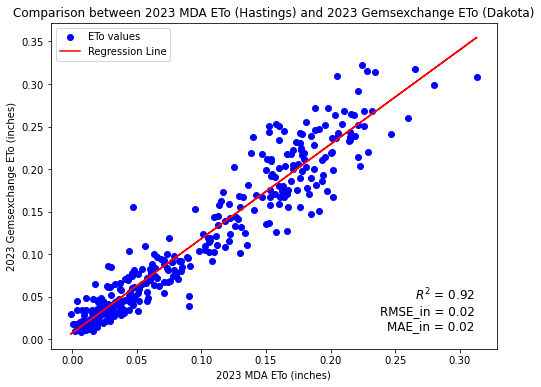

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer

# Assuming df_HastingsMDA_2023 and df_GEMS_Dakota2023 are your DataFrames containing observed MDA ETr and Gemsexchange ETr respectively

# Observed MDA ETr
mda_eto_Hastings2023 = df_HastingsMDA_2023['ETos_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etoDak2023 = df_GEMS_Dakota2023['ETo (in/day)'].values

# Handling missing values
imputer = SimpleImputer(strategy='mean')
mda_eto_Hastings2023 = imputer.fit_transform(mda_eto_Hastings2023)

# Fit linear regression model
model = LinearRegression()
model.fit(mda_eto_Hastings2023, gems_weatherbit_etoDak2023)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etoDak2023, model.predict(mda_eto_Hastings2023))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etoDak2023, model.predict(mda_eto_Hastings2023))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etoDak2023, model.predict(mda_eto_Hastings2023)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_eto_Hastings2023, gems_weatherbit_etoDak2023, color='blue', label='ETo values')
plt.plot(mda_eto_Hastings2023, slope * mda_eto_Hastings2023 + intercept, color='red', label='Regression Line')
plt.xlabel('2023 MDA ETo (inches)')
plt.ylabel('2023 Gemsexchange ETo (inches)')
plt.title('Comparison between 2023 MDA ETo (Hastings) and 2023 Gemsexchange ETo (Dakota)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


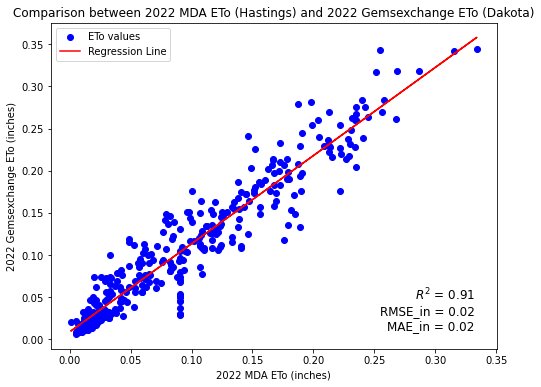

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer

# Assuming df_HastingsMDA_2022 and df_GEMS_Dakota2022 are your DataFrames containing observed MDA ETr and Gemsexchange ETr respectively

# Observed MDA ETr
mda_eto_Hastings2022 = df_HastingsMDA_2022['ETos_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etoDak2022 = df_GEMS_Dakota2022['ETo (in/day)'].values

# Handling missing values
imputer = SimpleImputer(strategy='mean')
mda_eto_Hastings2022 = imputer.fit_transform(mda_eto_Hastings2022)

# Fit linear regression model
model = LinearRegression()
model.fit(mda_eto_Hastings2022, gems_weatherbit_etoDak2022)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etoDak2022, model.predict(mda_eto_Hastings2022))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etoDak2022, model.predict(mda_eto_Hastings2022))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etoDak2022, model.predict(mda_eto_Hastings2022)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_eto_Hastings2022, gems_weatherbit_etoDak2022, color='blue', label='ETo values')
plt.plot(mda_eto_Hastings2022, slope * mda_eto_Hastings2022 + intercept, color='red', label='Regression Line')
plt.xlabel('2022 MDA ETo (inches)')
plt.ylabel('2022 Gemsexchange ETo (inches)')
plt.title('Comparison between 2022 MDA ETo (Hastings) and 2022 Gemsexchange ETo (Dakota)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


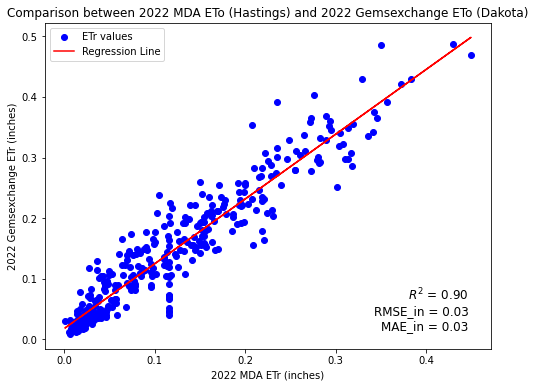

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer

# Assuming df_HastingsMDA_2022 and df_GEMS_Dakota2022 are your DataFrames containing observed MDA ETr and Gemsexchange ETr respectively

# Observed MDA ETr
mda_etr_Hastings2022 = df_HastingsMDA_2022['ETrs_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etrDak2022 = df_GEMS_Dakota2022['ETr (in/day)'].values

# Handling missing values
imputer = SimpleImputer(strategy='mean')
mda_etr_Hastings2022 = imputer.fit_transform(mda_etr_Hastings2022)

# Fit linear regression model
model = LinearRegression()
model.fit(mda_etr_Hastings2022, gems_weatherbit_etrDak2022)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etrDak2022, model.predict(mda_etr_Hastings2022))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etrDak2022, model.predict(mda_etr_Hastings2022))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etrDak2022, model.predict(mda_etr_Hastings2022)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_etr_Hastings2022, gems_weatherbit_etrDak2022, color='blue', label='ETr values')
plt.plot(mda_etr_Hastings2022, slope * mda_etr_Hastings2022 + intercept, color='red', label='Regression Line')
plt.xlabel('2022 MDA ETr (inches)')
plt.ylabel('2022 Gemsexchange ETr (inches)')
plt.title('Comparison between 2022 MDA ETo (Hastings) and 2022 Gemsexchange ETo (Dakota)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


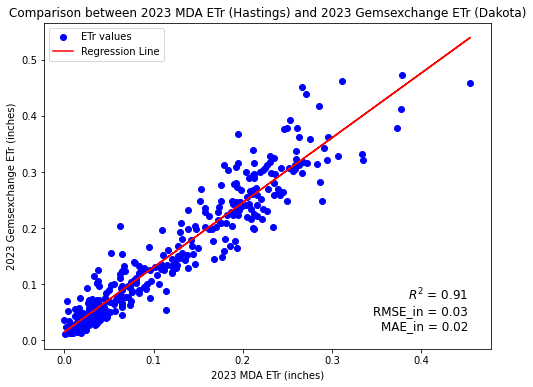

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer

# Assuming df_HastingsMDA_2023 and df_GEMS_Dakota2023 are your DataFrames containing observed MDA ETr and Gemsexchange ETr respectively

# Observed MDA ETr
mda_etr_Hastings2023 = df_HastingsMDA_2023['ETrs_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etrDak2023 = df_GEMS_Dakota2023['ETr (in/day)'].values

# Handling missing values
imputer = SimpleImputer(strategy='mean')
mda_etr_Hastings2023 = imputer.fit_transform(mda_etr_Hastings2023)

# Fit linear regression model
model = LinearRegression()
model.fit(mda_etr_Hastings2023, gems_weatherbit_etrDak2023)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etrDak2023, model.predict(mda_etr_Hastings2023))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etrDak2023, model.predict(mda_etr_Hastings2023))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etrDak2023, model.predict(mda_etr_Hastings2023)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_etr_Hastings2023, gems_weatherbit_etrDak2023, color='blue', label='ETr values')
plt.plot(mda_etr_Hastings2023, slope * mda_etr_Hastings2023 + intercept, color='red', label='Regression Line')
plt.xlabel('2023 MDA ETr (inches)')
plt.ylabel('2023 Gemsexchange ETr (inches)')
plt.title('Comparison between 2023 MDA ETr (Hastings) and 2023 Gemsexchange ETr (Dakota)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


### Douglas and Westport

In [55]:
import pandas as pd

# Load the CSV file
df_GEMS_Douglas2022 = pd.read_csv('Gemsexchage_data/gems_weather_export_douglas_2022-01-01_to_2022-12-31_units(M).csv')

# Make sure 'Date' is in datetime format
df_GEMS_Douglas2022['Date'] = pd.to_datetime(df_GEMS_Douglas2022['Date'])

#Rename columns if necessary
df_GEMS_Douglas2022.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1','solar_rad' : 'Rs_W_m2','max_temp' : 'Tmax_C' , 'min_temp':'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define your latitude and elevation
latitude = 0.7960 #  latitude of the location in radian
elevation = 409 #  the actual elevation of the location in meters #Here I kept same elevation as Becker. 

#  Call the ETref function
df_GEMS_Douglas2022 = ETref(df_GEMS_Douglas2022, latitude, elevation)

# Check the new columns added to your DataFrame
print(df_GEMS_Douglas2022.head)

<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4700   -24.0  72   971      333 2022-01-01   
1             1      1   4715   -16.0  78   970      335 2022-01-02   
2             2      2   4731    -4.0  84   966      336 2022-01-03   
3             3      3   4748    -8.0  91   953      338 2022-01-04   
4             4      4   4766   -12.0  82   962      340 2022-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4639   -14.0  75   972      328 2022-12-26   
360         360    360   4648    -3.5  83   952      329 2022-12-27   
361         361    361   4658     2.0  89   944      330 2022-12-28   
362         362    362   4670    -2.0  93   954      331 2022-12-29   
363         363    363   4682    -7.0  86   962      332 2022-12-30   

     max_wind_spd  precip_gpm  ...  Inverse Relative Distance Earth-Sun  \
0             4.4         0.0  ...        

In [54]:
import pandas as pd

# Load the CSV file
df_GEMS_Douglas2023 = pd.read_csv('Gemsexchage_data/gems_weather_export_douglas_2023-01-01_to_2023-12-31_units(M).csv')

# Make sure 'Date' is in datetime format
df_GEMS_Douglas2023['Date'] = pd.to_datetime(df_GEMS_Douglas2023['Date'])

#Rename columns if necessary
df_GEMS_Douglas2023.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1','solar_rad' : 'Rs_W_m2','max_temp' : 'Tmax_C' , 'min_temp':'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define your latitude and elevation
latitude = 0.7960 #  latitude of the location in radian
elevation = 409 #  the actual elevation of the location in meters #Here I kept same elevation as Becker. 

#  Call the ETref function
df_GEMS_Douglas2023 = ETref(df_GEMS_Douglas2023, latitude, elevation)

# Check the new columns added to your DataFrame
print(df_GEMS_Douglas2023.head)



<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4700      -4  96   962      333 2023-01-01   
1             1      1   4715      -6  94   967      335 2023-01-02   
2             2      2   4731      -4  90   958      336 2023-01-03   
3             3      3   4748      -3  89   958      338 2023-01-04   
4             4      4   4766      -5  88   964      340 2023-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4639       4  96   960      328 2023-12-26   
360         360    360   4648       0  95   967      329 2023-12-27   
361         361    361   4658       1  97   969      330 2023-12-28   
362         362    362   4670       4  90   964      331 2023-12-29   
363         363    363   4682      -2  89   961      332 2023-12-30   

     max_wind_spd  precip_gpm  ...  Inverse Relative Distance Earth-Sun  \
0             4.8         0.0  ...        

In [89]:
df_WestportMDA_2022 = pd.read_csv('MDAclean_data/Westport_clean_MDA_2022.csv')
df_WestportMDA_2023 = pd.read_csv('MDAclean_data/Westport_clean_MDA_2023.csv')

# Print the DataFrame
print(df_WestportMDA_2022)


            TIMESTAMP  RAIN_daily_in  RAIN_cmltv_in  AIRTEMP_daily_max_F  \
0      1/1/2022 23:59           0.00           0.00              -11.940   
1      1/2/2022 23:59           0.00           0.00                3.218   
2      1/3/2022 23:59           0.02           0.02               20.930   
3      1/4/2022 23:59           0.00           0.02               18.830   
4      1/5/2022 23:59           0.00           0.02               10.720   
..                ...            ...            ...                  ...   
359  12/26/2022 23:59           0.00          22.35                6.344   
360  12/27/2022 23:59           0.00          22.35               24.910   
361  12/28/2022 23:59           0.06          22.41               33.240   
362  12/29/2022 23:59           0.00          22.41               28.600   
363  12/30/2022 23:59           0.00          22.41               19.320   

        AIRTEMP_F_TMx  AIRTEMP_daily_min_F     AIRTEMP_F_TMn  \
0      1/1/2022 14:33  

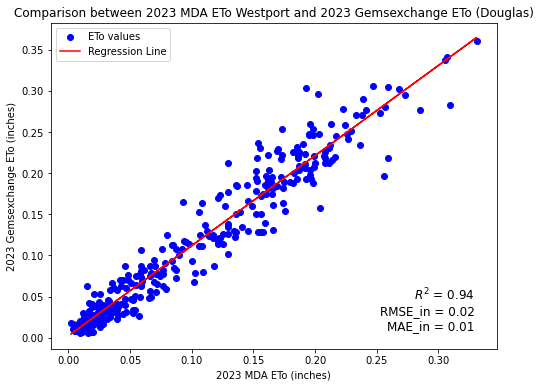

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Assuming df_Becker and df are your DataFrames containing observed MDA ETr and observed Gemsexchange ETr respectively

# Observed MDA ETo
mda_eto_Westport2023 = df_WestportMDA_2023['ETos_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETo
gems_weatherbit_etoDoug2023 = df_GEMS_Douglas2023['ETo (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_eto_Westport2023, gems_weatherbit_etoDoug2023)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etoDoug2023, model.predict(mda_eto_Westport2023))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etoDoug2023, model.predict(mda_eto_Westport2023))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etoDoug2023, model.predict(mda_eto_Westport2023)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_eto_Westport2023, gems_weatherbit_etoDoug2023, color='blue', label='ETo values')
plt.plot(mda_eto_Westport2023, slope * mda_eto_Westport2023 + intercept, color='red', label='Regression Line')
plt.xlabel('2023 MDA ETo (inches)')
plt.ylabel('2023 Gemsexchange ETo (inches)')
plt.title('Comparison between 2023 MDA ETo Westport and 2023 Gemsexchange ETo (Douglas)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


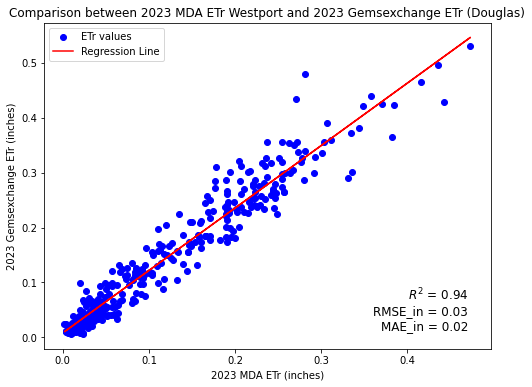

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Assuming df_Becker and df are your DataFrames containing observed MDA ETr and observed Gemsexchange ETr respectively

# Observed MDA ETr
mda_etr_Westport2023 = df_WestportMDA_2023['ETrs_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETo
gems_weatherbit_etrDoug2023 = df_GEMS_Douglas2023['ETr (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_etr_Westport2023, gems_weatherbit_etrDoug2023)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etrDoug2023, model.predict(mda_etr_Westport2023))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etrDoug2023, model.predict(mda_etr_Westport2023))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etrDoug2023, model.predict(mda_etr_Westport2023)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_etr_Westport2023, gems_weatherbit_etrDoug2023, color='blue', label='ETr values')
plt.plot(mda_etr_Westport2023, slope * mda_etr_Westport2023 + intercept, color='red', label='Regression Line')
plt.xlabel('2023 MDA ETr (inches)')
plt.ylabel('2023 Gemsexchange ETr (inches)')
plt.title('Comparison between 2023 MDA ETr Westport and 2023 Gemsexchange ETr (Douglas)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()
